<a href="https://colab.research.google.com/github/hyunbini/Project/blob/main/IDSL_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

Mounted at /content/drive


Function used in code

In [ ]:
def check_nan(file):
  result = file.isnull().sum()
  return result

In [ ]:
#Function that extracts user_id who wrote one or more reviews
#input : series(pandas dataframe)
#output : result(list)
def make_list(series1):
  result = []
  for i in range(series1.size):
    #Add user_id who have written reviews more than once to the new list
    if series1[i]>1:
      result.append(series1.index[i])
  return result

In [ ]:
#Function that erases unnecessary characters and makes a list of only the necessary data
#input : list1(list)
#output : result_listset(list)
def remove_special(list1):
  #Change list to string
  for i in range(len(list1)):
    list1[i] = str(list1[i])
  listset_str = ' '.join(list1)
  #Remove Special characters to space
  listset_str = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', "",listset_str)
  #Split the data by space
  result_listset = listset_str.split(' ')
  return result_listset

In [ ]:
#Function that labels data composed of complex characters numerically based on ascending order\
#input : list1(list to be replaced), list2(reference list), dic(dictionary to store the values of reference list and its unique labeling numbers)
#output : list_df(Dataframe made from a labeled list)
def labeling(list1,list2,dic):
  i = 0
  for data in list1:
    if data in list2:
      if data in dic.keys():
        list1[i] = dic[data]
      else:
        dic[data] = i
        list1[i] = i
      i = i+1
    else:
      list1[i] = i
      i = i+1
  for y in range(len(list1)):
    list1[y] = list1[y]+1
  list_df = pd.DataFrame(data=list1, columns= ['label_id'])
  return list_df

Import Data and Remove NaN Value and Unuseful Columns



In [ ]:
meta_json = pd.read_json('/content/drive/MyDrive/IDSL Recruitment/[Data 1] Eng - Review Analysis/metadata.json')
review_json = pd.read_json('/content/drive/MyDrive/IDSL Recruitment/[Data 1] Eng - Review Analysis/reviews.json')
print(check_nan(meta_json))
print(check_nan(review_json))

main_category          0
title                  0
average_rating         0
rating_number          0
features               0
description            0
price                  0
images                 0
videos                 0
store               1105
categories             0
details                0
parent_asin            0
bought_together    11257
subtitle           11257
author             11257
dtype: int64
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64


In [ ]:
metadata = meta_json.drop(['rating_number','categories','videos', 'details', 'bought_together', 'subtitle', 'author'],axis = 1)
print(metadata.head())
review = review_json.drop(['title', 'text','images','timestamp','user_id','helpful_vote','verified_purchase'],axis=1)
print(review.head())

  main_category                                              title  \
0    All Beauty  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1    All Beauty  Lurrose 100Pcs Full Cover Fake Toenails Artifi...   
2    All Beauty                         Gold extatic Musk EDT 90ml   
3    All Beauty  Brand New Headrang Face line Contour V-line Ma...   
4    All Beauty  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...   

   average_rating                                           features  \
0             4.8                                                 []   
1             3.7  [The false toenails are durable with perfect l...   
2             3.7  [Extatic Balmain Gold Musk By Balmain Edt Spra...   
3             3.3                                                 []   
4             3.4                                                 []   

                                         description  price  \
0                                                 []   None   
1  [Description, The

Extracting duplicate data and labeling of the user_id value to be used for prediction

In [ ]:
id = review_json['user_id']
print("The total number of reviews is", id.size)
id_count = (id.value_counts())
print("The user who wrote the review is", id_count.size)
dup_ind = make_list(id_count)

The total number of reviews is 70883
The user who wrote the review is 68934


<ipython-input-5-17c3463facae>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series1[i]>1:


In [ ]:
new_user_id = id.to_list()
result_dup_id = remove_special(dup_ind)
result_user_id = remove_special(new_user_id)
label_dic = {}
label_df = labeling(result_user_id,result_dup_id,label_dic)

Data Visualization

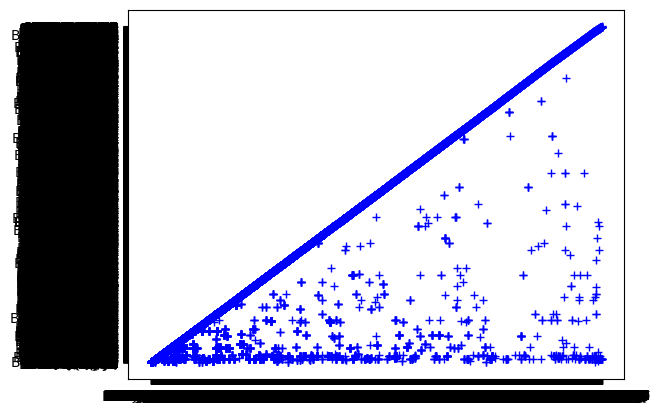

In [ ]:
asin = review['asin']
asin_parent = review['parent_asin']
plt.plot(asin,asin_parent, 'b+')
plt.show()

One-hot encoding

In [ ]:
#https://naomy-gomes.medium.com/the-cosine-similarity-and-its-use-in-recommendation-systems-cb2ebd811ce1
#https://www.kaggle.com/code/muhammadayman/recommendation-system-using-cosine-similarity

def ohe(df, enc_col):
    '''
    One hot encodes specified columns and adds them back
    onto the input dataframe
    '''

    ohe_df = pd.get_dummies(df[enc_col])
    ohe_df.reset_index(drop = True, inplace = True)
    return pd.concat([df, ohe_df], axis = 1)

print(ohe(metadata, 'parent_asin'))
print(ohe(review, 'parent_asin'))

Modeling

In [ ]:
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))
def recommend(book_id, owner_id, df):
    """
    Content based recommendations.
    Calls the cosine similarity function to calculate similarities and returns the
    most similar books, excluding the ones listed by the user
    """
    book_id = book_id - 1 #because it starts from zero in the csv, while the ids in the database start from 1

    # calculate similarity of input book_id vector and all other vectors in the table
    inputVec = df.loc[book_id].values #gets values of the book_id inputed
    df['sim']= df.apply(lambda x: cos_sim(inputVec,x.values), axis=1)  #goes through all the book vectors in the table
                                                         #and creates a column containing the values of the cosine similarity

    df_rec = df.nlargest(10, columns='sim')#gets only the 10 most similars (10 bigger values of the cosine similarity)
    df_final = df_rec.loc[df['owner_id'] != owner_id]#excludes books already listed by the user
    # returns up to 10 similar books that the user didnt list already
    return df_final

Prediction